In [ ]:
"""
Name: Ethan Ling
Email: ethan.ling95@myhunter.cuny.edu
Pod: Rear left
"""

# Program 4: geospatial analysis of 911 ambulance requests in NYC

In [2]:
import json

import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
import seaborn as sns

from plotly import express as px

Matplotlib is building the font cache; this may take a moment.


## Section 1: obtain and explore the data

In this exercise you'll be working with with the [NYPD 911 Calls For Service dataset](https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Year-to-Date-/n2zq-pubd/about_data). In particular, you'll be looking at a subset of the data: ambulance calls between 2024-01-01 and 2024-09-31.

#### Task 1.1: Download and import the data
Export the Ambulance calls data table from the NYC Open Data portal. You can find the subset with the necessary filters applied (and some non-necessary columns removed) [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Year-to-Date-/n2zq-pubd/explore/query/SELECT%0A%20%20%60incident_date%60%2C%0A%20%20%60incident_time%60%2C%0A%20%20%60boro_nm%60%2C%0A%20%20%60typ_desc%60%2C%0A%20%20%60arrivd_ts%60%2C%0A%20%20%60closng_ts%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%0AWHERE%0A%20%20%28%60create_date%60%0A%20%20%20%20%20BETWEEN%20%222024-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20AND%20%222024-10-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%29%0A%20%20AND%20caseless_contains%28%60typ_desc%60%2C%20%22AMBULANCE%20CASE%3A%22%29/page/filter). Export it as a CSV, move it to your notebook's working directory, and name your file `911-ambulance-calls-2024-Jan-Sep.csv`. Finally, import the data into a pandas dataframe named `ambulance_calls_df`.

In [3]:

ambulance_calls_df = pd.read_csv('911-ambulance-calls-2024-Jan-Sep.csv')

# Display the first few rows of the DataFrame to confirm successful import
print(ambulance_calls_df.head())


  INCIDENT_DATE INCIDENT_TIME        BORO_NM  \
0    01/01/2024      00:01:10  STATEN ISLAND   
1    01/01/2024      00:01:10  STATEN ISLAND   
2    01/01/2024      00:02:07      MANHATTAN   
3    01/01/2024      00:04:19          BRONX   
4    01/01/2024      00:04:27      MANHATTAN   

                             TYP_DESC ARRIVD_TS               CLOSNG_TS  \
0         AMBULANCE CASE: EDP/OUTSIDE       NaN  01/01/2024 12:57:30 AM   
1         AMBULANCE CASE: EDP/OUTSIDE       NaN  01/01/2024 12:58:37 AM   
2  AMBULANCE CASE: UNCONSCIOUS/INSIDE       NaN  01/01/2024 12:07:55 AM   
3      AMBULANCE CASE: SERIOUS/INSIDE       NaN  01/01/2024 03:07:00 AM   
4  AMBULANCE CASE: UNCONSCIOUS/INSIDE       NaN  01/01/2024 12:57:12 AM   

    Latitude  Longitude  
0  40.529657 -74.230212  
1  40.529657 -74.230212  
2  40.759150 -73.960844  
3  40.816088 -73.895824  
4  40.722053 -73.988215  


#### Task 1.2 Clean up the table

1. rename `CLOSNG_TS` to `closing_ts` and `ARRIVD_TS` to `arrived_ts` for readability; then convert them to datetime type. You may want to consult the docs for the `pd.to_datetime()` function and python's datetime string formatting options [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) and [here](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).
1. combine `"INCIDENT_DATE"` and `"INCIDENT_TIME"` into a single datetime column called `"incident_ts"`; then, drop the original `"INCIDENT_DATE"` and `"INCIDENT_TIME"` to avoid redundancy
1. make the remaining column names snake case for typing ease

Finally, display the cleaned-up table.

In [ ]:
print(ambulance_calls_df.columns)

ambulance_calls_df.rename(columns={
    'CLOSNG_TS': 'closing_ts',
    'ARRIVD_TS': 'arrived_ts',
    'INCIDENT_DATE': 'incident_date',
    'INCIDENT_TIME': 'incident_time'
}, inplace=True)

ambulance_calls_df['closing_ts'] = pd.to_datetime(ambulance_calls_df['closing_ts'])
ambulance_calls_df['arrived_ts'] = pd.to_datetime(ambulance_calls_df['arrived_ts'])

if 'incident_date' in ambulance_calls_df.columns and 'incident_time' in ambulance_calls_df.columns:
    ambulance_calls_df['incident_ts'] = pd.to_datetime(
        ambulance_calls_df['incident_date'] + ' ' + ambulance_calls_df['incident_time']
    )
    ambulance_calls_df.drop(columns=['incident_date', 'incident_time'], inplace=True)
else:
    print("Error: 'incident_date' and/or 'incident_time' column is missing.")

ambulance_calls_df.columns = [
    column.lower().replace(' ', '_') for column in ambulance_calls_df.columns
]


Index(['boro_nm', 'typ_desc', 'arrived_ts', 'closing_ts', 'latitude',
       'longitude', 'incident_ts'],
      dtype='object')
Error: 'incident_date' and/or 'incident_time' column is missing.


In [13]:
# Display the cleaned-up table
print(ambulance_calls_df.head())


         boro_nm                            typ_desc arrived_ts  \
0  STATEN ISLAND         AMBULANCE CASE: EDP/OUTSIDE        NaT   
1  STATEN ISLAND         AMBULANCE CASE: EDP/OUTSIDE        NaT   
2      MANHATTAN  AMBULANCE CASE: UNCONSCIOUS/INSIDE        NaT   
3          BRONX      AMBULANCE CASE: SERIOUS/INSIDE        NaT   
4      MANHATTAN  AMBULANCE CASE: UNCONSCIOUS/INSIDE        NaT   

           closing_ts   latitude  longitude         incident_ts  
0 2024-01-01 00:57:30  40.529657 -74.230212 2024-01-01 00:01:10  
1 2024-01-01 00:58:37  40.529657 -74.230212 2024-01-01 00:01:10  
2 2024-01-01 00:07:55  40.759150 -73.960844 2024-01-01 00:02:07  
3 2024-01-01 03:07:00  40.816088 -73.895824 2024-01-01 00:04:19  
4 2024-01-01 00:57:12  40.722053 -73.988215 2024-01-01 00:04:27  


#### Task 1.3: Compute time intervals

Before moving on, compute two new derived columns: the `total_seconds()` elapsed between
- the incident was reported until it was closed; call the new column `"duration_secs"`
- the incident was reported until help arrived; call this new column `"arrived_in_secs"`

In [15]:
ambulance_calls_df['duration_secs'] = (
    (ambulance_calls_df['closing_ts'] - ambulance_calls_df['incident_ts']).dt.total_seconds()
)

ambulance_calls_df['arrived_in_secs'] = (
    (ambulance_calls_df['arrived_ts'] - ambulance_calls_df['incident_ts']).dt.total_seconds()
)

print(ambulance_calls_df[['duration_secs', 'arrived_in_secs']].T)


                 0       1       2        3       4       5       6       \
duration_secs    3380.0  3447.0   348.0  10961.0  3165.0  1085.0  4176.0   
arrived_in_secs     NaN     NaN     NaN      NaN     NaN   851.0  1391.0   

                 7       8       9       ...  518941  518942  518943  518944  \
duration_secs    6027.0  1717.0  6474.0  ...  1317.0  2946.0   794.0  7512.0   
arrived_in_secs     NaN     NaN     NaN  ...     NaN     0.0   791.0    12.0   

                 518945  518946  518947  518948  518949  518950  
duration_secs    3646.0  1477.0  3010.0  2024.0  2980.0  3635.0  
arrived_in_secs  3643.0    63.0  3001.0  1597.0     NaN     NaN  

[2 rows x 518951 columns]


## Section 2: Exploratory analysis
#### Task 2.1: Explore the time intervals
Now that you've created these new columns, let's take a look at them. Start by showing summary stats of new columns you created using the `.describe()` method on those two columns. Pass the argument `percentiles=[.25, .5, .75, .9, .95]` to get the quartiles as well as the 90th and 95th percentiles. Transpose the table using the resulting `T` attribute for easier readability.

In [16]:
summary_stats = ambulance_calls_df[["duration_secs", "arrived_in_secs"]].describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]
).T

print(summary_stats)


                    count         mean          std  min     25%     50%  \
duration_secs    518948.0  3919.704907  4573.669156  3.0  1562.0  2667.0   
arrived_in_secs  215163.0  1240.136413  2158.346964  0.0   230.0   568.0   

                    75%     90%      95%       max  
duration_secs    4574.0  7664.0  10944.0  422761.0  
arrived_in_secs  1371.0  3035.0   4756.0  153327.0  


Now plot the cumulative distribution functions using seaborn's `ecdfplot()` function. Plot both cumulative distributions together in the same chart, calling `sns.ecdfplot()` twice in the same notebook cell. Use the `label` parameter to add meaningful names to your legend. Also, call `plt.xlim()` to set the x-axis limits to `0-20000` and `plt.xlabel()` to set the label to `"time in seconds"`. Finally, call `plt.legend()` to generate a legend in your chart.

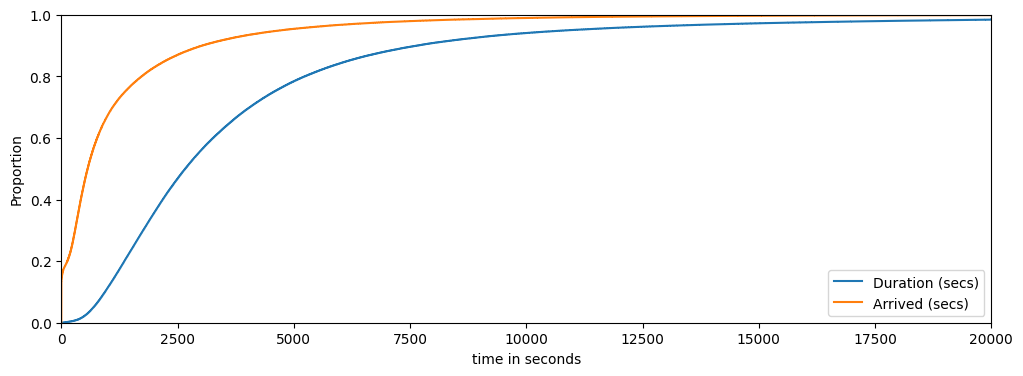

In [17]:
plt.figure(figsize=(12, 4))
sns.ecdfplot(data=ambulance_calls_df, x="duration_secs", label="Duration (secs)")
sns.ecdfplot(data=ambulance_calls_df, x="arrived_in_secs", label="Arrived (secs)")
plt.xlim(0, 20000)
plt.xlabel("time in seconds")
plt.legend()
plt.show()

#### Task 2.2: Conclusions about time series intervals
What conclusions do you reach after analyzing these two variables? Write at least three observations:

> - 2.2 #1: ...
> - 2.2 #2: ...
> - 2.2 #3: ...
> 
> ...

#### Task 2.3: Probability distributions by borough

Now, let's look at these distributions by borough. You will do so via kernel density estimation plots with `sns.kdeplot()`.

First though, call matplotlib `plt.subplots()` to make a chart with two columns and a figure size of `(12, 4)`, storing the function outputs (a tuple) as `fig, ax`. Then invoke `sns.kdeplot()`, passing the the `hue` parameter so that each borough is represented with a different line. To treat each borough times as independent distributions, set the `common_norm` parameter to `False`. And to assign the chart to each of the two subplots, you'll need to pass the values `ax[0]` or `ax[1]` to the `ax` parameter. Finally, cut out the outliers from the KDE setting `clip` to `(-1, 20000)` for the `"duration_secs"` column and to `(-1, 10000)` for the `"arrived_in_secs"` column.

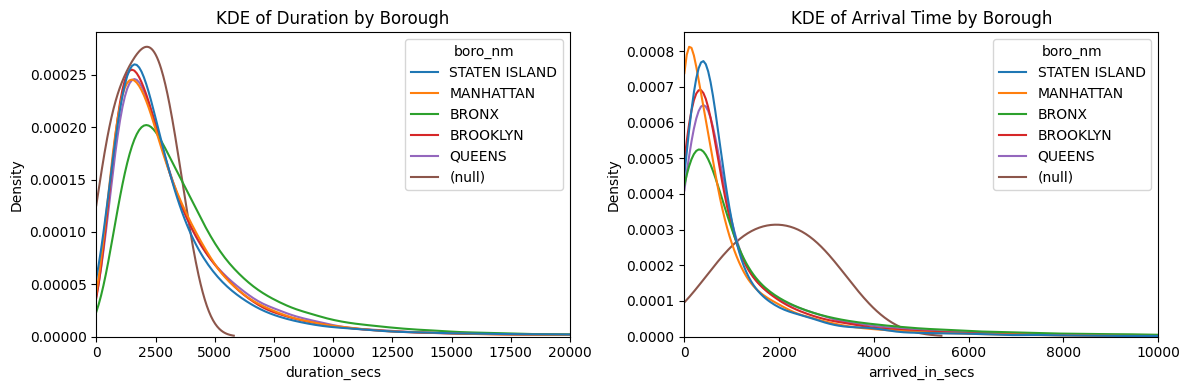

In [21]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# KDE plots for "duration_secs" by borough
sns.kdeplot(
    data=ambulance_calls_df,
    x="duration_secs",
    hue="boro_nm",
    common_norm=False,
    clip=(-1, 20000),
    ax=ax[0]
)
ax[0].set_title("KDE of Duration by Borough")
ax[0].set_xlim(-1, 20000)

# KDE plots for "arrived_in_secs" by borough
sns.kdeplot(
    data=ambulance_calls_df,
    x="arrived_in_secs",
    hue="boro_nm",
    common_norm=False,
    clip=(-1, 10000),
    ax=ax[1]
)
ax[1].set_title("KDE of Arrival Time by Borough")
ax[1].set_xlim(-1, 10000)

# Display the plots
plt.tight_layout()
plt.show()


What stands out to you from these charts? Make at least two observations.

> - 2.3 #1: ...
> - 2.3 #2: ...
>   
> ...

## Section 3: Aggregations in a choropleth map

You saw that the 911 calls requesting an ambulance all have a latitude and longitude associated with them. That allows us to represent data geographically on a map!

#### Task 3.1: Get NYC boro geometries
First, you'll need the shapefiles or geojson files with the NYC borough boundaries. You can find them [here](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm). Download the borough boundaries in geojson format, move it to your notebook's working directory, and call your file `borough-boundaries.geojson`. 

Then, use the [geopandas](https://geopandas.org/en/stable/index.html) library, imported above as `gpd`. First, use the `read_file()` function to read your geojson file into a geodataframe called `nyc_boros`. Then, display the geodataframe.

In [22]:

geojson_file = 'borough-boundaries.geojson'

# Read the GeoJSON file into a GeoDataFrame
try:
    nyc_boros = gpd.read_file(geojson_file)
    
    # Display the GeoDataFrame
    print(nyc_boros)
except FileNotFoundError:
    print(f"File '{geojson_file}' not found. Ensure it is in the working directory.")
except Exception as e:
    print(f"An error occurred: {e}")

  boro_code      boro_name     shape_area     shape_leng  \
0         3       Brooklyn  1934142775.63  728147.130565   
1         5  Staten Island  1623618684.31  325910.306061   
2         1      Manhattan  636646082.483  360037.525777   
3         2          Bronx  1187174772.32  463180.578878   
4         4         Queens   3041418003.6  888197.010944   

                                            geometry  
0  MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
1  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
2  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
3  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
4  MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...  


In [ ]:
# display the geodataframe with the NYC boroughs
nyc_boros

#### Task 3.2: First look at a geodataframe

This is (probably) your first time looking at a geodataframe. What do you notice? Write at least two observations:

> - 3.2 #1: ...
> - 3.2 #2: ...
> - ...

#### Task 3.3: Choropleth map of typical arrival times by borough
Now let's use these geometries together with the ambulance data to make an interactive choropleth map of the typical arrival time of help after a call is made on the five boroughs. You will also display other quantities a hover properties.

First off, aggregate `ambulance_calls_df` into a new dataframe called `calls_by_boro` which should have the following columns: 
- `"boro_nm"`
- `"num_calls"`
- `"median_arrived_in_secs"`
- `"median_duration_secs"`

Before you group your dataframe, you should remove any rows where `"arrived_in_secs"` is not larger than `0` (clearly something is wrong with those data points), as well as rows where the borough name or the `"arrived_ts"` are null or missing. 

_**Hint**: you may find the `.agg()` dataframe method helpful to apply different aggregation functions to different columns._

In [ ]:
# aggregate ambulance_calls_df by borough
calls_by_boro = ...

In [ ]:
# display the dataframe
calls_by_boro

Then, merge the `calls_by_boro` pandas dataframe into the `nyc_boros` geodataframe. Make sure to call `nyc_boros.merge(...)`, as the resulting object will preserve the type of the left frame. Name the new table `choropleth_gdf`. Finally, set the frame's index to `"boro_name"` and display it.

In [ ]:
choropleth_gdf = ...

In [ ]:
# display the new geodataframe
choropleth_gdf

Now you have a single geodataframe with the geometries for each borough and a number of metrics describing them. This is all you need to make your choropleth map with plotly.

You'll be using the `choropleth_mapbox(...)` function of the `plotly.express` module (imported above with the typical alias `px`). You can find the documentation [here](https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html). Call the function setting the following parameters:
- `data_frame`: this is your geodataframe containing the borough-level data; it's important that the index is a unique label to each geometry.
- `geojson`: an array or `pandas.Series` with the geometries associated to each element.
- `locations`: an array containing your location identifiers. In our case, `choropleth_gdf.index` is a good choice.
- `color`: column name contaning values to be represented in choropleth: `"median_arrived_in_secs"`
- `hover_data`: additional column names with data to be represented when hovering over a geometry; let's include `["num_calls", "median_duration_secs"]`, but feel free to add others.
- `labels`: a dictionary with the display names for different plot properties. Use this to make your column names more human readable:
  -  `"boro_name": "borough"` 
  - `"num_calls": "number of calls"`
  - `"median_arrived_in_secs": "median arrival time (seconds)"`
  - `"median_duration_secs": "median duration time (seconds)"`
- `title` (optional): a title for your choropleth!
- `mapbox_style`: set this to `"carto-darkmatter"` to make a map with a black background, but feel free to play with other styles too (see [docs](https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html)).
- `center`: set this to `{"lat": 40.75, "lon": -74.0}` to center the map in NYC
- `zoom`: set this to `9`:
- `height`: set it to `750`
- `width`: set it to `750`

Store the output of your function call as `choropleth_fig`, and finally call `choropleth_fig.show();` to display your choropleth.

In [ ]:
# make and show the choropleth
choropleth_fig = px.choropleth_mapbox(
    ...
)

choropleth_fig.show();

#### Task 3.4: Analyze the choropleth
What do you observe in your choropleth? Write at least two thoughts:

> - 3.4 #1: ...
> - 3.4 #2: ...
> 
> - ...

## Section 4: scatter map of individual calls
Now let's make a geographic scatterplot of individual ambulance call arrival times using the `px.scatter_mapbox()` function (docs [here](https://plotly.com/python-api-reference/generated/plotly.express.scatter_mapbox.html)).

For this map you won't need a geodataframe as `ambulance_calls_df` contains latitude and longitude columns and `scatter_mapbox()` can take those as arguments. 

#### Task 4.1: Make a new dataframe for the scattermap
First, make a new pandas dataframe called `new_years_df` that is a subset of `ambulance_calls_df` with
- `"incident_ts"` being equal to `"2024-01-01"`
- no missing/null values

In [ ]:
new_years_df = ...

#### Task 4.2: Create the scatter map
Now you'll create your scatter map. You'll do this in two steps: first you'll create the scatter map, then you'll add the boro boundaries as another layer.

Storing its result as `scatter_fig`, call `px.scatter_mapbox` passing the following parameters:
- `data_frame`
- `lat`
- `lon`
- `size`
- `opacity`
- `color`
- `title`
- `zoom`
- `height`
- `width`

That will create the scatter map (feel free to check your work before moving on). Then, call `scatter_fig.update_layout()`, setting the `mapbox_layers` parameter to the following value:

```python
[{
    "type": "line",
    "color": "white",
    "opacity": 0.5,
    "source": json.loads(nyc_boros["geometry"].to_json()),
    "line": {"width": 0.1},
}]
```

Finally, call `scatter_fig.update_layout(mapbox_style="carto-darkmatter")` to set the theme and call `scatter_fig.show()` to display your map.

In [ ]:
scatter_fig = px.scatter_mapbox(...
)

scatter_fig.update_layout(...)

scatter_fig.update_layout(...)

scatter_fig.show();

#### Task 4.3: The slowest arrival
Zoom into your map and look aronud a bit. Can you spot the call with the slowest arrival? Write its latitude and longitude here:
> - latitude: 40.681268 	
> - longitude: -73.892877